# __Segmentacion de Comercio Online__

## Importar librerias

In [1]:
# librerias para el dataframe y la visualizacion
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# librerias para la clusterizacion
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

## Cargar los datos

In [2]:
retail_df = pd.read_csv('./OnlineRetail.csv', sep=',', encoding='ISO-8859-1', header=0)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
# tamano del dataset
retail_df.shape

(541909, 8)

> El dataset presenta 541.909 registros y solo 8 columnas.

In [4]:
# tipo de dato de cada variable
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


> 5 de las 8 variables son de tipo object. Hay que tenerlo en cuenta. 

## Acerca de los datos

Este es un conjunto de datos con todas las transacciones realizadas entre el 01/12/2010 y el 09/12/2011 para una tienda online sin establecimientos físicos con sede en el Reino Unido. La empresa vende principalmente regalos únicos para cualquier ocasión. Muchos de sus clientes son mayoristas.

Las variables que contienen los datos son:

- _InvoiceNo_: Numero de factura. Es un numero entero de 6 digitos asignado de forma unica a cada transaccion. si este codigo empieza con la letra "c", indica una cancelacion.

- _StockCode_: Codigo de stock del producto. Es un numero de 5 digitos asignado de forma unica a cada producto.

- _Description_: Nombre del producto.

- _Quantity_: Cantidades de cada producto por transaccion.

- _InvoiceDate_: Fecha de factura. Marca el dia y la hora en que se genero cada transaccion.

- _UnitPrice_: Precio del producto por unidad.

- _CustomerID_: Numero integral de 5 digitos asignado de forma unica a cada cliente.

- _Country_: Nombre del pais donde reside cada cliente.

El objetivo es segmentar a los clientes en funcion del __RFM__ para que la empresa pueda dirigirse a sus clientes de manera eficiente. El __RFM__ es una tecnica basada en 3 variables que indican el valor y comportamiento de compra de cada cliente. Estas son: Recency (tiempo que ha pasado desde la ultima compra), Frequency (frecuencia de compra del cliente) y Monetary (dinero total gastado).

## Resumen estadistico de las variables numericas

In [5]:
retail_df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


__Sobre Cantidad__

> Hay 541.909 datos, valor que coincide con la cantidad de registros. Esto indica que la variable no presenta valores faltantes.

> Presenta una media de 9.5 unidades por transaccion.

> El valor de std es muy alto (218.08) lo que indica que los datos estan muy dispersos probablemente por la presencia de valores atipicos. La distribucion no es normal.

> 25% de las transacciones tienen 1 o 0 unidades.

> 50% de las transacciones tienen 3 o menos unidades.

> 75% tienen 10 o menos unidades.

> El valor de min es negativo lo que posiblemente representa devoluciones.

__Sobre Precio Unitario__

> Presenta la misma cantidad de registros lo que nos indica que la variable no presenta valores faltantes.

> La media es de 4.61$ por unidad.

> El valor de std es muy alto (96.76$) lo que sugiere la presencia de precios muy altos.

> El valor de min es negativo lo cual no es valido. Sugiere la presencial de outliers.

> 25% de las transacciones son de 1.25$.

> 50% de las transacciones son de 2.08$.

> 75% de las transacciones son de 4.13$.

__Sobre CustomerID__

> Presenta 406.829 datos, lo que difiere considerablemente con la cantidad total de registro lo que implica la presencia de valores nulos. 

> Esta variable es un identificador de los clientes por lo que no tiene un significado estadistico relevante.

## Resumen estadistico de las variables categoricas

In [6]:
retail_df.describe(include=['object'])

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,31-10-2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


__Sobre Numero de factura__

> Presenta la misma cantidad de registros lo que indica que no hay valores nulos.

> Existen 25900 facturas unicas, o mejor dicho, 25900 clientes.

> La factura mas frecuente es la 573585 con 1114 apariciones.

__Sobre el codigo del producto__

> Presenta la misma cantidad de registros lo que indica que no hay valores nulos.

> Hay 4070 productos diferentes.

> El producto mas vendido tiene el codigo 85123A el cual ha sido vendido 2313 veces.

__Sobre la Descripcion__

> Hay 540.455 descripciones. Faltan 1.454 descripciones que probablemente sean valores nulos.

> El producto mas frecuente de acuerdo a su descripcion fue "WHITE HANGING HEART T-LIGHT HOLDER" cuya presencia fue de 2369 veces.

__Sobre Fecha y Hora de la factura__

> No presenta valores nulos.

> Hay 23.260 momentos diferentes de venta

> El momento donde hubo mayor cantidad de venta fue 31-10-2011 a las 14:41 con un valor de 1114 ventas.

__Sobre Pais__

> No presenta valores nulos.

> Se vendio a clientes de 38 paises.

> El pais con mayor transacciones fue Reino unido con un total de 495.478 ventas.

## Limpieza de datos

### Porcentaje de valores faltantes por variable

In [7]:
df_nulo = round(retail_df.isnull().sum()/len(retail_df)*100, 2)
df_nulo

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

> El 24.93% de valores en CustomerID son valores faltantes. Esto representa un alto procentaje de clientes que no podemos identificar.

> El 0.27% de los valores en Description son faltantes. Es una cifra pequeña en comparacion con la otra variable que posee. Ademas, esta variable no es tan significativa para nuestro objetivo.

> Procedemos a eliminar los registros  con valores faltantes en la variable CustomerID.

In [8]:
retail_df = retail_df.dropna(subset=['CustomerID'])
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


>  El resumen nos muestra que los valores faltantes en Description correspondian a valores faltantes en CustomerID por lo que todo el dataframe quedo libre de valores faltantes.

### Cambiar el tipo de dato de CustomerID segun en entendimiento comercial

In [9]:
# convertir CustomerID a string
retail_df['CustomerID'] = retail_df['CustomerID'].astype(str)
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      406829 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 27.9+ MB


## Preparacion de los datos

Vamos a analizar a los clientes mediante tres variables:

- R (Recency): Tiempo que ha pasado desde la ultima compra.
- F (Frecuencia): Numero de transacciones por cliente.
- M (Monetary): Importe total de transacciones por cliente.

Vamos a obtener estas tres variables a partir de los datos dados.

### __Monetary__

In [10]:
# calcular el total de cada transaccion y guardamos en una nueva columna
retail_df['Amount'] = retail_df['Quantity']*retail_df['UnitPrice']

# calcular el gasto total por cliente
rfm_m = retail_df.groupby('CustomerID')['Amount'].sum()

# convertir serie en un dataframe
rfm_m = rfm_m.reset_index()

rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


### __Frequency__

In [11]:
# contar la cantidad de facturas de cada cliente
rfm_f = retail_df.groupby('CustomerID')['InvoiceNo'].count()

# convertir serie en dataframe
rfm_f = rfm_f.reset_index()

# renombrar columnas para que sean claras
rfm_f.columns = ['CustomerID', 'Frequency']

rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


### __Recency__

In [12]:
# convertir fecha y hora al tipo de dato adecuado
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], format='%d-%m-%Y %H:%M')

In [13]:
# calcular la fecha maxima para conocer la fecha de la ultima transaccion
max_date = max(retail_df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [14]:
# calcular la diferencia entre la fecha maxima y la fecha de cada transaccion
# guardar en una nueva columna
retail_df['Diff_dates'] = max_date - retail_df['InvoiceDate']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff_dates
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [15]:
# Calcular la fecha de la ultima transaccion para obtener la antiguedad de los clientes
rfm_r = retail_df.groupby('CustomerID')['Diff_dates'].min()

# convertir serie en dataframe
rfm_r = rfm_r.reset_index()

rfm_r.head()

,CustomerID,Diff_dates
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [16]:
# Extraer solo el numero de dias
rfm_r['Diff_dates'] = rfm_r['Diff_dates'].dt.days
rfm_r.head()

,CustomerID,Diff_dates
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


### __Unir variables en un df__

In [17]:
rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm = pd.merge(rfm, rfm_r, on='CustomerID', how='inner')

# renombrar columnas
rfm.columns = ['CustomerID', 'Monetary', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Monetary,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


### __Tratar Outliers__

Trataremos los outliers ya que alteran la distribucion de los datos como percatamos en los resumenes estadisticos. Existen dos tipos de outliers:

- Estadisticos.

- De dominio especifico.

__Analisis de Outliers en Monetary, Frequency y Recency__

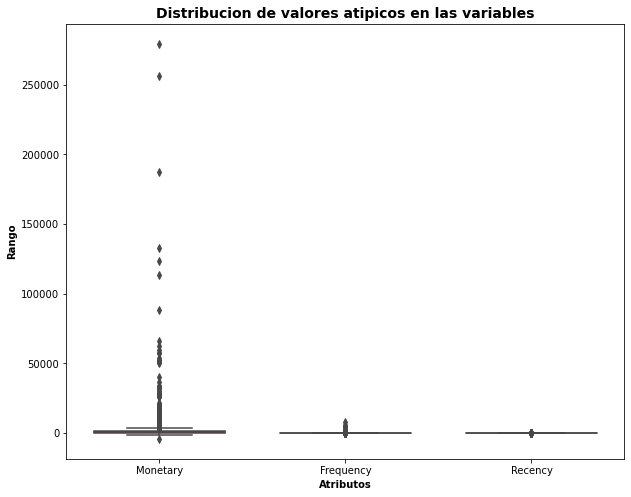

In [18]:
# definimos las variables a analizar
atributos = ['Monetary', 'Frequency', 'Recency']

# ajustar tamano del grafico en pulgadas
plt.rcParams['figure.figsize'] = [10, 8]

# boxplot
sns.boxplot(
    data=rfm[atributos], 
    orient='v',         # orientacion del grafico
    palette='Set1',     # paleta de colores
    whis=1.5,           # limite del bigote. 1.5 veces el IQR
    saturation=1,       # intensidad de color maximo
    width=0.7           # ancho de la caja
    )

# propiedades del grafico
plt.title('Distribucion de valores atipicos en las variables', fontsize=14, fontweight='bold')
plt.ylabel('Rango', fontweight='bold')
plt.xlabel('Atributos', fontweight='bold')
plt.show()

> Monetary presenta una gran cantidad de outliers. La mayoria de sus datos se concentran cerca del eje inferior. Hay ciertos clientes que han gastado cantidades muy altas (mayores a 250.000) lo que genera una distribucion muy sesgada.

> Frequency presenta algunos outliers. La mayoria de los clientes han comprado pocas veces. Unos pocos clientes compran muy frecuentemente (clientes leales)

> Recency presenta pocos outliers. La mayoria de los clientes hicieron su ultima compra en un rango cercano.

In [19]:
# cantidad de registros en rfm
regis = rfm.shape[0]
print('Registros totales de rfm: ', regis)

Registros totales de rfm:  4372


__Remover outliers estadisticos en Monetary__

In [20]:
# calcular el rango intercuartil
Q1 = rfm.Monetary.quantile(0.05)
Q3 = rfm.Monetary.quantile(0.95)
IQR = Q3 - Q1

# omitir clientes que esten fuera del rango de 1.5 veces IQR
rfm = rfm[(rfm.Monetary >= Q1 - 1.5*IQR) & (rfm.Monetary <= Q3 + 1.5*IQR)]

# cantidad de registros sin outliers en Monetary
regis_m = rfm.shape[0]
print('Registros totales de rfm sin outliers en Monetary: ', regis_m)
print('Registros eliminados: ', regis - regis_m)
print('Porcentaje eliminado: ', round(((regis - regis_m)/regis)*100, 2))

Registros totales de rfm sin outliers en Monetary:  4313
Registros eliminados:  59
Porcentaje eliminado:  1.35


__Remover outliers estadisticos en Recency__

In [21]:
# calcular el rango intercuartil
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1

# omitir clientes que esten fuera del rango de 1.5 veces IQR
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# cantidad de registros sin outliers en Recency y monetary
regis_mr = rfm.shape[0]
print('Registros totales de rfm sin outliers en Monetary y en Recency: ', regis_mr)
print('Registros eliminados: ', regis_m - regis_mr)
print('Porcentaje eliminado: ', round(((regis_m - regis_mr)/regis_m)*100, 2))

Registros totales de rfm sin outliers en Monetary y en Recency:  4313
Registros eliminados:  0
Porcentaje eliminado:  0.0


__Remover outliers estadisticos en Frequency__

In [22]:
# calcular el rango intercuartil
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1

# omitir clientes que esten fuera del rango de 1.5 veces IQR
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

# cantidad de registros sin outliers en ningun atributo
regis_mrf = rfm.shape[0]
print('Registros totales libres de outliers: ', regis_mrf)
print('Registros eliminados: ', regis_mr - regis_mrf)
print('Porcentaje eliminado: ', round(((regis_mr - regis_mrf)/regis_mr)*100, 2))

Registros totales libres de outliers:  4293
Registros eliminados:  20
Porcentaje eliminado:  0.46


### __Reescalando variables__

Este proceso es importante para que todas las variables tengan una misma escala.

In [26]:
# seleccionamos las variables del dataframe
rfm_df = rfm[['Monetary', 'Frequency', 'Recency']]

# instanciamos el escalador
scaler = StandardScaler()

# ajustamos el escalador a los datos
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled

array([[-0.72373821, -0.75288754,  2.30161144],
       [ 1.73161722,  1.04246665, -0.90646561],
       [ 0.30012791, -0.46363604, -0.18365813],
       ...,
       [-0.67769602, -0.70301659,  0.86589794],
       [-0.6231313 , -0.64317145, -0.84705678],
       [ 0.32293822, -0.07464263, -0.50050524]])

In [27]:
# convertimos serie en dataframe
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Monetary', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Monetary,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


## Construir el Modelo K-Means

Este modelo requiere inicializarlo con un numero de clustering definido. Vamos a iniciar con un numero de clustering de 4.

In [29]:
# instanciamos el modelo
kmeans = KMeans(n_clusters=4, max_iter=50, n_init=10, random_state=42)

# entrenamos el modelos con los datos escalados
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4, n_init=10, random_state=42)

Verifiquemos que el modelo entrenado presente las etiquetas de los 4 clusteres

In [30]:
kmeans.labels_

array([1, 0, 3, ..., 1, 3, 3], dtype=int32)

### Encontrar el numero optimo de clusteres

Vamos a implementar dos tecnicas muy comunes para encontrar la cantidad optima de clusteres que debemos utilizar en K-Means

__Metodo del codo__

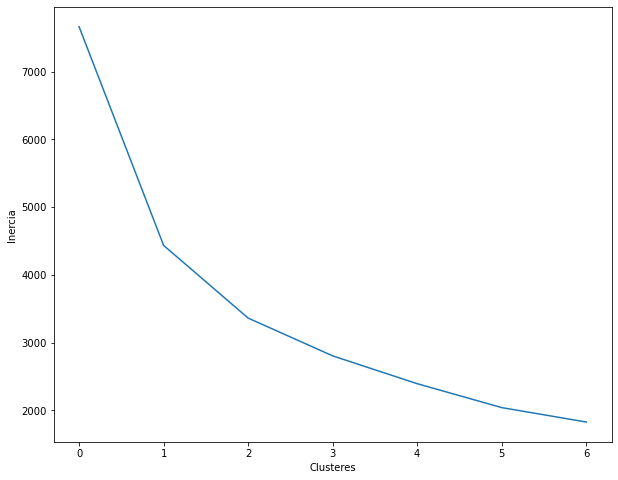

In [31]:
# lista para guardar la inercia de cada K
inercia = []

# definir el rango de K a probar
K = range(2, 9)

# iteramos sobre el modelo para cada valor de K
for n_cluster in K:
    kmeans = KMeans(n_clusters=n_cluster, max_iter=50, n_init=10, random_state=42)
    kmeans.fit(rfm_df_scaled)
    inercia.append(kmeans.inertia_)

plt.plot(inercia)
plt.xlabel('Clusteres')
plt.ylabel('Inercia')
plt.show()

> El grafico muestra la mayor perdida de inercia en el cluster 1. Sin embargo, el cluster 3 presenta un punto de inflexion en cuanto a la perdida de inercia.

__Indice de Silueta__

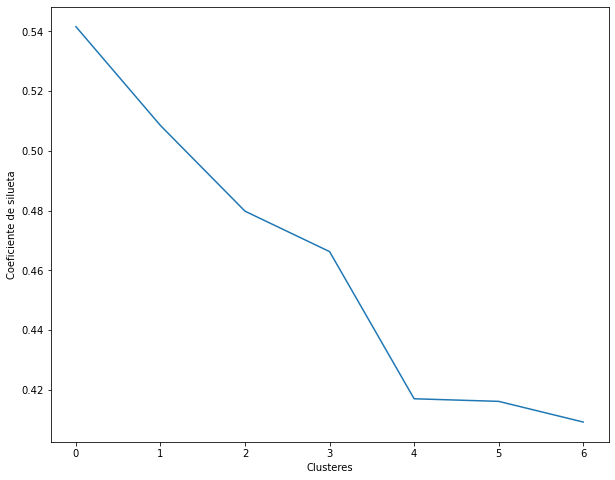

In [32]:
# lista para guardar los indice de silueta para cada cluster
index_silueta = []

# rango de K a probar
K = range(2, 9)

# itermaos el modelo para cada valor de K
for n_cluster in K:
    kmeans = KMeans(n_clusters=n_cluster, n_init=10, max_iter=50, random_state=42)
    y_pred = kmeans.fit_predict(rfm_df_scaled)
    index_silueta.append(silhouette_score(rfm_df_scaled, y_pred))

plt.plot(index_silueta)
plt.xlabel('Clusteres')
plt.ylabel('Coeficiente de silueta')
plt.show()

> La grafica muestra que hasta el cluster 3 el coeficiente de silueta no decae tanto.

### Modelo optimo de clusterizacion

Ambos metodos sugieren que con un numero de cluster igual a 3 podemos obtener un modelo de clusterizacion optimo. 

In [33]:
kmeans = KMeans(n_clusters=3, n_init=10, max_iter=50, random_state=42)
kmeans.fit(rfm_df_scaled)

# asignamos la etiqueta de clusterizacion a cada cliente del df
rfm['Cluster_K'] = kmeans.labels_
rfm.head() 

,CustomerID,Monetary,Frequency,Recency,Cluster_K
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,2
3,12349.0,1757.55,73,18,2
4,12350.0,334.40,17,309,1
